<a id='logbook'></a>
# Prediction of ship roll decay motion using fully nonlinear potential flow and Ikeda’s method
This is the notebook that created this paper. If you want to recreate this paper from the very beginning you must first run some other notebooks, according to the [summary](00.0_summary.ipynb).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import copy
from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import src.visualization.visualize as visualize
import scipy
from copy import deepcopy
import joblib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if os.name == 'nt':
    plt.style.use('paper.mplstyle')  # Windows

from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize
from rolldecayestimators import equations_ikeda_naked
from sympy import latex
from rolldecayestimators import logarithmic_decrement
from copy import deepcopy
import src.helpers
from src.notebook_to_latex import Equation, equation_dict

## Examples:
from reports import mdl_results
import reports.examples as examples
import reports.examples.ikeda_V_phi_a
import reports.examples.analytical_numerical
import reports.examples.eddy_sigma
import reports.examples.ikeda_section_table
import reports.examples.decision_tree
import reports.examples.KVLCC2_section_table
import reports.examples.logaritimic_decrement
import reports.examples.mdl
from reports.examples.mdl import plot_amplitudes
import reports.examples.ikeda
import reports.examples.hybrid_0
import reports.examples.hybrid_speed
import reports.examples.FNPF
import reports.examples.KVLCC2

Duplicate key in file 'paper.mplstyle', line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file 'paper.mplstyle', line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf','png')
from IPython.display import HTML, Markdown, Image
from src.df_to_latex import LateXTable

# Abstract
Many cost-efficient computational methods have been developed over the
years to analyze various aspects of ship hydrodynamics such as:
resistance, propulsion and seakeeping. Getting the best possible
accuracy with the lowest possible computational cost is an important
factor in a ship's early design stage. Potential flow-based analysis
partly presents such a solution for seakeeping, with good accuracy for
heave and pitch, but not for roll where the roll damping contains both
inviscid and viscous effects. Roll motion is, however, often a critical
degree of freedom that needs to be analyzed since large roll motions can
result in cargo shifting or even capsizing. The viscous part of roll
damping can be assessed with high accuracy by means of experimental
model tests or URANS calculations, but these are generally too expensive
in the early design stage of ships. Many semi-empirical formulas to
determine viscous damping were therefore developed during the 1970s,
where Ikeda's method is one of the most widely used. The viscous damping
from this method is normally combined with inviscid roll damping from
strip theory. With today's computational power, more advanced potential
flow methods can be used in the seakeeping analysis to enhance the
accuracy in the predictions, but still at relatively low computational
cost. This paper investigates the feasibility of a hybrid method: combining 3D unsteady
fully nonlinear potential flow (FNPF) theory solved by means of a
Boundary Element Method (BEM) together with the viscous contributions
from Ikeda's method. Roll decay simulations with the hybrid method show very good agreement with corresponding model tests for the investigated KVLCC2 test case. This kind of hybrid method can therefore improve the accuracy of the roll motions in seakeeping analysis with nonlinear potential flow simulations. 

# Introduction
Inviscid potential flow calculations can be used to solve seakeeping problems at very low computational costs. These methods offer far cheaper alternatives than doing for instance model tests or URANS calculations. Potential flow calculations can therefore be used extensively during the early design stage of ships. The pitch and heave motions can be predicted with good accuracy, even with the older linear strip theory methods <cite data-cite="7505983/FB64RGPF"></cite>. The roll motions will however not be very realistic in potential flow, due to high influenced from viscous roll damping. This is very unfortunate as the roll motions is indeed a very important response. The impact of roll motions can be seen from the APL China casualty in 1998, where a post-Panamax C11 class container ship lost almost a third of its containers <cite data-cite="7505983/WPADAQB3"></cite>. Another example is the container ship Svendborg Maersk, were 500 containers were lost overboard and 250 containers were damaged as a result of heavy roll motions during a passage from English Channel to Gibraltar <cite data-cite="7505983/T78CMTDR"></cite>.

A lot of experimental research was conducted during the 1970s and 80s to separate the invicid and viscous roll damping. Semi empirical formulas were developed to estimate the viscous parts, to be used together with the potential flow methods <cite data-cite="7505983/937PN5DT"></cite>. 
The older linear methods can today be replaced by more advanced nonlinear potential flow methods. These newer methods still need some injection of semi empirical viscous damping to give a fair representation of the roll motions. But is the separation of damping components still valid, considering that these older semi empirical methods were developed in close connection to linear strip theory? <cite data-cite="7505983/UGK6YEVD"></cite> have shown that the separation of viscous and invicid damping is still valid for a panel method and Ikeda's method to predict the roll motion for the mentioned APL China vessel. <cite data-cite="7505983/24TNAV5Z"></cite> have investigated an even more advanced method, using a fully nonlinear potential flow method (FNPF) <cite data-cite="7505983/P4XDUMMQ"></cite> combined with Watanabe and Inoue method (W-I) <cite data-cite="7505983/ARMIRMVY"></cite> to predict the viscous damping for the DTC test case <cite data-cite="7505983/BYNJ8CFG"></cite>. This FNPF method is used also in the present paper, but instead of W-I method, Ikeda's method is instead used. Ikeda's method is believed to be a good method for the purpose, based on results from a previous comparisons of a large number of model scale roll decay tests <cite data-cite="7505983/QMGQ76Q9"></cite>.

The implementation of the proposed hybrid method is introduced in the next section where the underlying Ikeda's method and FNPF method are both presented. The implementation of Ikeda's method is also closely examined and an alternative way to calculate eddy damping is proposed. In the validation study of the hybrid method, roll decay tests from model tests are compared with simulations for the KVLCC2 test case. In the roll decay tests, both decay and frequency can be observed, without the presence of external forces from wind and waves. This gives a good indication of the ship's roll damping and inertia. A more thorough description of the roll decay test is given in the Roll decay test section of this paper.

#  Proposed hybrid method
A hybrid method is proposed in this paper, where wave damping $B_W$ (including the speed dependent wave damping)  obtained implicitly with FNPF is used together with the viscous damping contributions from Ikeda's method. The viscous damping is added to the FNPF simulations by injecting the viscous parts of the linear and quadratic damping coefficients (obtained with Ikeda's method) to the equation of motion. Ikeda's method divides roll damping into five damping components so that the total damping can be calculated as <cite data-cite="7505983/937PN5DT"></cite>,
\begin{equation}
B = B_F + B_E + B_L + B_W + B_{BK}
\end{equation}
Where $B_F$ is the skin friction component, $B_E$ is the eddy generation component, $B_L$ is hull lift component, $B_W$ is roll wave generation component and $B_{BK}$  is the bilge keel component. Ikeda's method propose semi empirical formulas for the viscous damping components: $B_F$, $B_E$, $B_{BK}$ and $B_L$ so that viscous damping can be obtained from, 
<a id='eq_viscous_damping'>
\begin{equation}
\label{eq:viscous_damping}
B_{visc} = B_F + B_E + B_L
\end{equation}

In order to reduce the number of uncertain parameters, the bilge keel damping $B_{BK}$ has been exluded in Eq.[(above)](#eq_viscous_damping), thereby assuming that the ship does not have any bilge keels. 

The skin friction damping $B_F$ is calculated using <cite data-cite="7505983/CKCMI3N9"></cite> which is implementation according to the description in <cite data-cite="7505983/UGK6YEVD"></cite> with the difference that the actual wetted surface at rest $S$ was used instead of the proposed estimation formula. The scale effects of roll damping are considered to mainly be associated with the skin friction component $B_F$ <cite data-cite="7505983/FB64RGPF"></cite>. This component constitute a very small part of the total damping for the full scale ship, but a substantial part for the model scale ship used in this study. This is therefore the only component in Ikedas method that needs to be recalculated when the scale changes.  

The hull lift damping $B_L$ is calculated according to <cite data-cite="7505983/937PN5DT"></cite> and implemented as described in <cite data-cite="7505983/UYUAYY7E"></cite> where the calculations have been improved with a linear interpolation of the values for $\kappa$ from <cite data-cite="7505983/937PN5DT"></cite>.

Ikeda's method calculates the roll damping at a certain roll angle frequency $\omega$ and roll angle amplitude $\phi_a$. A schematic graph of how the parameters vary with speed and roll angle amplitude $\phi_a$ is shown in Fig.[(below)](#fig_ikeda_generic). In this figure, roll amplitude is first varied at zero speed (left). The speed is then varied at constant roll angle amplitude of 10 degrees (middle). The amplitude is then gradually reduced at the highest speed down to zero again (right). 

Assumming that the trends are correct in Ikeda's method it can be noted from the amplitude variations at zero knots (left):
* $B_W$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping. (The $B_W$ was calculated with strip theory here)
* $B_F$ has a small amplitude dependancy but the linear part is dominating.
* $B_E$ has a large amplitude depandancy and only contributes to the quadratic damping ($B_2$)<cite data-cite="7505983/4AFVVGNT"></cite>.

Looking at the speed variation (middle):
* At low speed $B_F$ and $B_E$ are the dominating components. (Note that this ship does not have bilge keels, as that would otherwise also be a large component).
* At high speed the $B_E$ has almost disappeared and is replaced by the $B_L$ which is now the dominating component.
* $B_F$ has a large contribution for all speeds (at model scale).

Looking at the roll amplitude variation (right):
* (Please note that this x-axis is revered in this graph)
* $B_L$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping.
* $B_F$ has a small amplitude dependancy but the linear part is dominating.

<a id='fig_ikeda_generic'></a>

findfont: Font family ['"serif"'] not found. Falling back to DejaVu Sans.


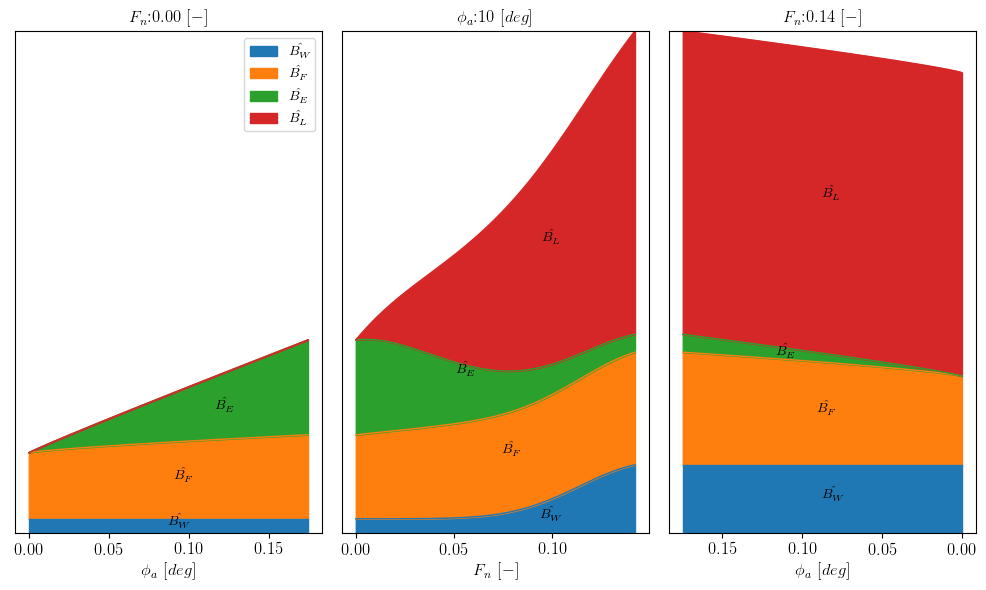

In [5]:
examples.ikeda_V_phi_a.show()

When the damping predicted with Ikeda's method was compared with corresponding
model tests, it was found that the results were in poor agreement for the
zero speed case but quite good results at speed. This was pointing
towards the eddy damping being incorrect in the current implementation
of Ikeda's method. A thorough investigation of the eddy damping
prediction was therefore conducted which is described in the next
section.

## Eddy damping
The eddy damping is due to eddies generated around the ship hull during the roll motion. Strong eddies occures at sharp edges in the geometry. Fig.[(see)](#fig_eddy_sigma) is an illustration of how the eddy damping changes with bilge radius as predicted with the current implementation of the method. It seems that the damping approaches zero very fast as the bilge radius increase. Having just a small rounding of the bilge, compared to a square section, will thereby have a great impact on the eddy roll damping.  

<a id='fig_eddy_sigma'></a>

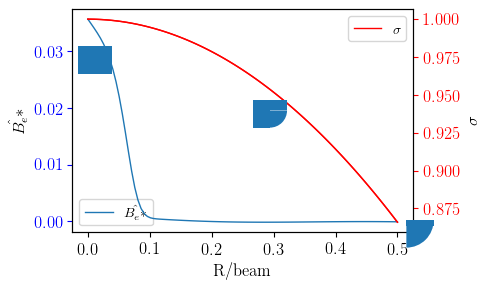

In [6]:
examples.eddy_sigma.show()

The eddy damping prediction is based on a regression formula from experiements on a number of two-dimensional cylinders with various sections <cite data-cite="7505983/4AFVVGNT"></cite>. The eddy damping per unit length of these sections can be expressed as: <a id='eq_eddy_section'></a>

In [7]:
Equation(equations_ikeda_naked.eq_B_E0s, label='eq:eddy_section')

<src.notebook_to_latex.Equation object>

The total eddy damping can be obtained as an integral over the sections along the ship hull:

In [8]:
Equation(equations_ikeda_naked.eq_B_E0, label='eq:eddy_integration')

<src.notebook_to_latex.Equation object>

It can be seen from the section damping (Eq.[here](#eq_eddy_section)) that the eddy damping increases linearly with both roll amplitude and frequency, and that it will go to zero for small amplitudes and frequencies. This means that eddy damping is only included in the quadratic damping term ($B_2$). The $C_r$ coefficient in (Eq.[here](#eq_eddy_section)) is assumed to be entirely depending on the hull form and is calculated using the regression formula in <cite data-cite="7505983/4AFVVGNT"></cite>. This regression formula is based on: section area coefficient $\sigma$ and the Lewis section coefficients: $a_1$ and $a_3$. An alternative regression formula for $C_r$ has however been developed for this paper, as described below. This regression is based the same experimental results <cite data-cite="7505983/4AFVVGNT"></cite>, collected by the authors using manual digitalization <cite data-cite="7505983/RXYIE6UW"></cite>. 

In [10]:
examples.ikeda_section_table.show()

model,$\hat{\omega}$,$\phi_a$,$\hat{B_E}^*$,B_W+B_F,$L_{pp}$,$beam$,$T_s$,$\sigma$,$R_b$,$a_1$,$a_3$,$C_r$
A,0.7509999999999999,0.23,0.03753367571367666,0.0036357630291343353,0.8,0.28,0.112,1.0,0.0,0.0957206732772989,-0.13851394050431068,6.791066236924099
A,0.507,0.24,0.028412505258521625,0.001390847207830892,0.8,0.28,0.112,1.0,0.0,0.0957206732772989,-0.13851394050431068,7.297514558176527
B,0.7509999999999999,0.3,0.02070022681130489,0.003265431521957657,0.8,0.28,0.112,0.997,0.01,0.0959495614824,-0.13645394665840074,2.862276498613118
B,0.536,0.3,0.013327670129715686,0.0011106958095124797,0.8,0.28,0.112,0.997,0.01,0.0959495614824,-0.13645394665840074,2.5820572246775733
C,0.7509999999999999,0.27,0.006150584844546503,0.0021146614051981705,0.8,0.28,0.112,0.995,0.02,0.09610173289389053,-0.13508440395498614,0.9426864035197876
C,0.625,0.21,0.003986684713683185,0.0015000392814414284,0.8,0.28,0.112,0.995,0.02,0.09610173289389053,-0.13508440395498614,0.9439893821974792
D,0.9390000000000001,0.31,0.007465704560231518,0.0020385726488099023,0.8,0.28,0.112,0.988,0.03,0.0966318006065463,-0.13031379454108408,0.7906835390460062
D,0.7509999999999999,0.31,0.006144708627086015,0.0015002944963602304,0.8,0.28,0.112,0.988,0.03,0.0966318006065463,-0.13031379454108408,0.8136897536952461
G,0.8140000000000001,0.24,0.011504995055307304,0.08835564931140577,0.8,0.185,0.192,0.799,0.18239704162959489,-0.3470782119390985,-0.007600489480668136,0.08606062205238542
H,0.56,0.3,0.0006398363737784848,0.0014000371877776175,0.8,0.398,0.193,0.893,0.1957020442368476,0.014252111702710272,-0.0688620354229256,0.059677264135571374


Where $OG/d=0$ for all sections. For the Series60 sections (G-K) the bilge radius $R_b$ was estimated using the following estimation, proposed by the authors:

In [11]:
Equation(equations_ikeda_naked.eq_R_b, label='eq:R_b')

<src.notebook_to_latex.Equation object>

The nondimensional damping taken from <cite data-cite="7505983/4AFVVGNT"></cite> is expressed using an asterisk, or star symbol (*), to emphase that this component only has a quadratic part of the damping. This stared damping is defined as:

In [12]:
Equation(equations_ikeda_naked.eq_B_E_star_hat, label='eq:B_E_star_hat')

<src.notebook_to_latex.Equation object>

$\hat{B_E^*}$ and $(B_W+B_F)^*$ are the experimental values taken from <cite data-cite="7505983/4AFVVGNT"></cite>. Which add up to the total damping:

In [13]:
Equation(equations_ikeda_naked.eq_B_star_hat, label='eq:B_star_hat')

<src.notebook_to_latex.Equation object>

And the $C_r$ can be calculated from the experiments as:

In [14]:
Equation(equations_ikeda_naked.eq_C_r_2, label='eq:C_r_2')

<src.notebook_to_latex.Equation object>

A simple decision tree model is used for the $C_r$ regression, based on the same Lewis section coefficients from the regular regression formula. The fitted decision tree is illustrated in Fig.[(see)](#fig_decision_tree).

<a id='fig_decision_tree'></a>

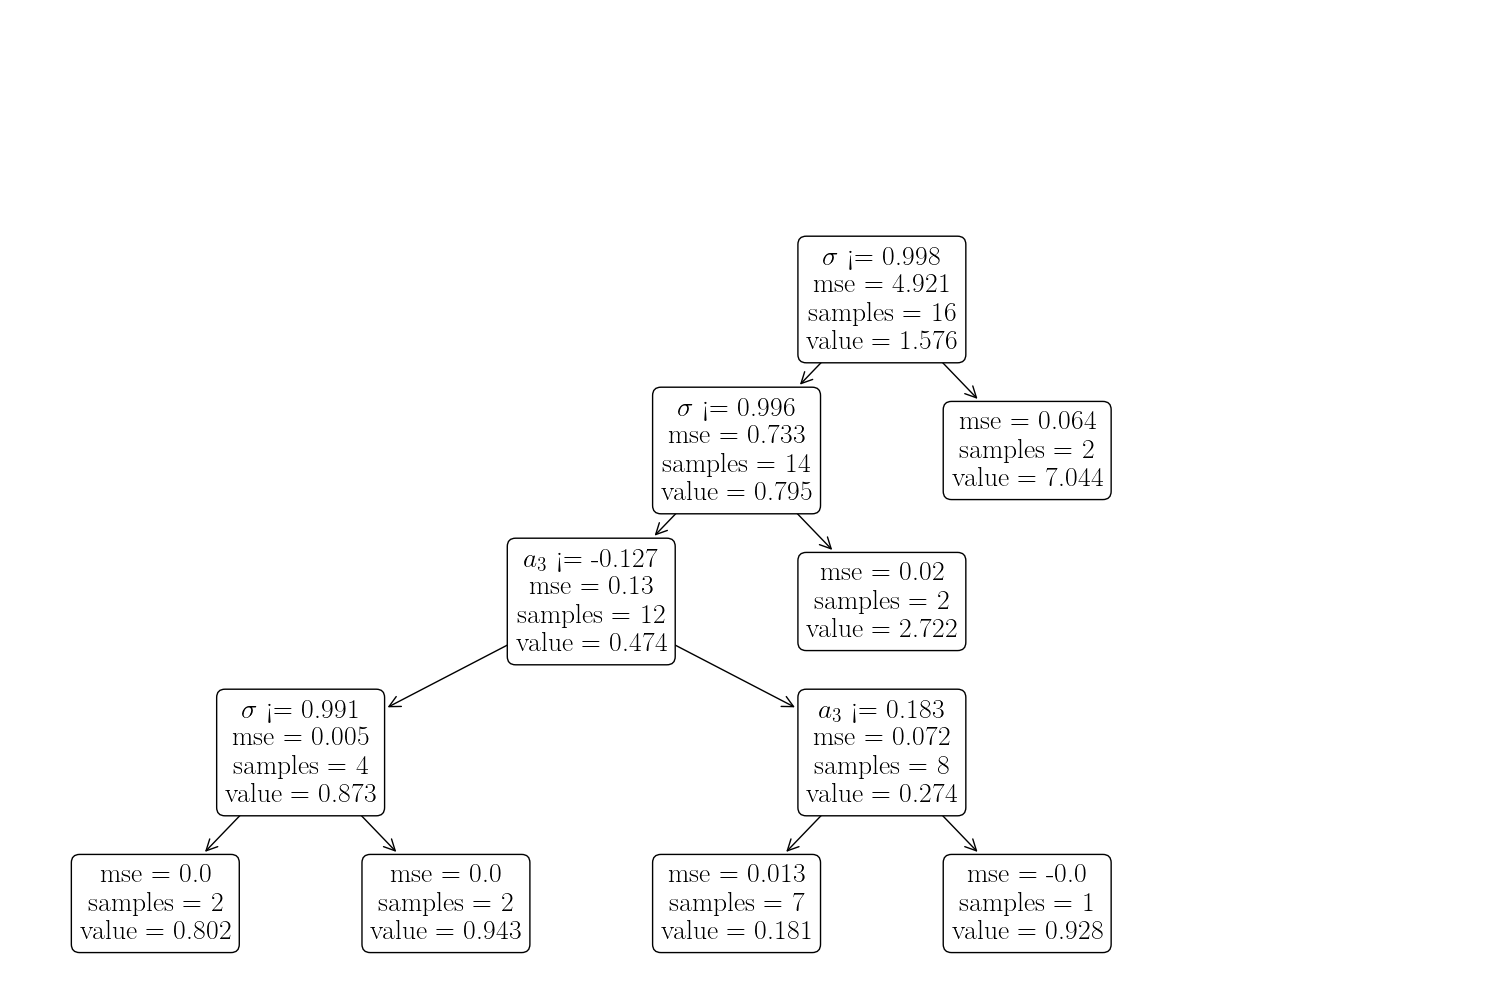

In [15]:
examples.decision_tree.show()

Even thoug this tree is very simple it has very good accuracy in reproducing the results from Ikedas experiments ($r^2=0.996)$.

## FNPF method
\label{fnpf-method}
The wave damping was obtained using parameter an identification technique, as described in section: [PIT method](#se_pit), on roll decay simulation using the fully nonlinear potential flow method. This method is characterized by the application of the complete dynamic and kinematic free surface boundary conditions on the instantaneous free surface as well as the body-exact approach where the instantaneous wetted body surface is considered in the boundary value problem for the velocity potential, i.e. no linearizations are made to the governing equations of the potential flow problem.

The method used in this study employs a boundary element method (BEM) <cite data-cite="7505983/FD4N3DW2"></cite> to solve the boundary value problem for the velocity potential.

The free surface boundary conditions and the motions of the floating body introduce time dependency to the boundary value problem. The BEM is coupled with the mixed Eulerian-Lagrangian method (MEL) <cite data-cite="7505983/ZKB494GT"></cite> which is used for the evolution of free surface. A fourth-order Adams-Bashforth-Moulton time integral scheme is then used to evolve free surface and the rigid-body body motions in time.

The benefit with the FNPF method is the lack of linearizations to the free surface potential flow where all interactions between the undisturbed incident flow and surface piercing body is captured implicitly in the total velocity potential, including inviscid (wave) damping due to radiation and diffraction. The downside is the larger computational cost compared to many other potential flow based methods due to the fact that a boundary value problem for the velocity potential must be solved at least once every time step, depending on the specifics of the time integral scheme. However, FNPF methods are still typically less computationally demanding than for example URANS methods, making them attractive choices for seakeeping problems.

# Roll decay test

A common way to determine the roll damping of a ship is to
conduct a roll decay test. The initial heel angle during this test gives
the ship potential energy that subsequently is shifting to kinetic energy as the ship
starts to oscillate during the initial phase of the roll decay test. The
energy is transferred between kinetic and potential energy during the
oscillations. The ship loses energy over time due to the damping as shown in Fig.[(below)](#fig_energy):

<a id='fig_energy'></a>

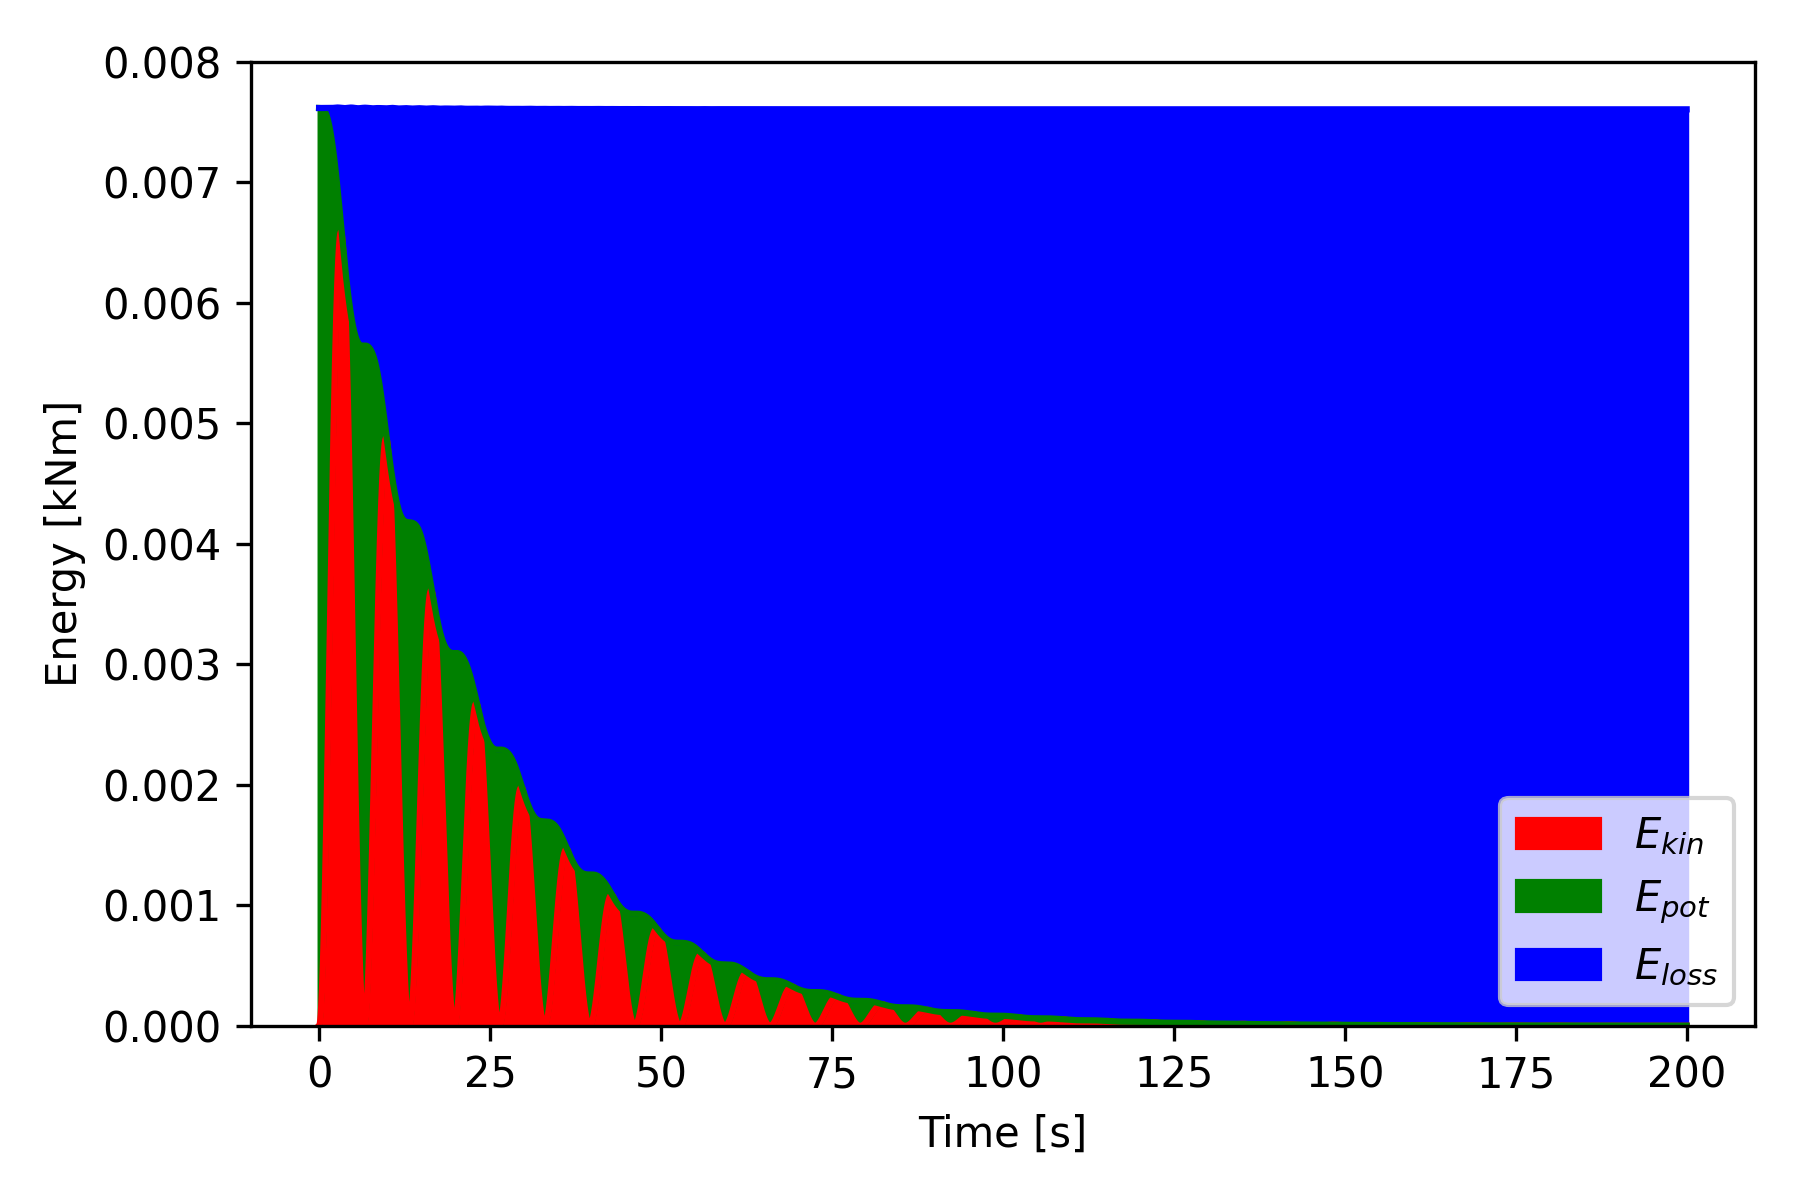

In [16]:
Image('../figures/energy_transfer.png')

Time traces of the roll decay roll motion, from model tests as well as from FNPF and hybrid method simulations are used in this paper to determine the roll damping. Two different techniques to identify the damping from these tests are used: the PIT method, described in the next section and the logarithmic decrement method as described in <cite data-cite="7505983/BYNJ8CFG"></cite>. [(and here)](02.1.appendix_extras.ipynb#se_time_and_frequency)

## PIT method to estimate damping
<a id='se_pit'></a>
\label{se:pit}

A parameters identification technique (PIT) similar to <cite data-cite="7505983/EXYJELCU"></cite> is used to obtain the damping coefficients from the roll decay tests. In this technique, parameters in a mathematical model are determined in order to get the best fit to a roll decay time signal. A derivation of a mathematical model suitable for this study is described below together with a description of how the parameters: damping, stiffness and inertia coefficients are determined. The roll decay motion can be expressed in general form according to <cite data-cite="7505983/KL7A3RIV">  </cite> which is the same equation as in <cite data-cite="7505983/FB64RGPF"></cite> but with nonlinear stiffness:

In [17]:
Equation(equations.roll_decay_equation_general_himeno, label='eq:roll_decay_equation_general_himeno')

<src.notebook_to_latex.Equation object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping <cite data-cite="7505983/FB64RGPF"></cite>:

In [18]:
Equation(equations.b44_cubic_equation, label='eq:b44_cubic_equation')

<src.notebook_to_latex.Equation object>

And a higher order stiffness model <cite data-cite="7505983/KL7A3RIV"></cite>:

In [19]:
Equation(equations.restoring_equation_cubic, label='eq:restoring_equation_cubic')

<src.notebook_to_latex.Equation object>

The total equation is then written:

In [20]:
Equation(equations.roll_decay_equation_cubic, label='eq:roll_decay_equation_cubic', max_length=200)

<src.notebook_to_latex.Equation object>

This mathematical model can be reduced to a quadratic damping model when $B_3=0$ and a linear model when $B_2=B_3=0$. This equation does not have one unique solution however. If all parameters would be  multiplied by a factor $k$ these parameters would also yield as a solution to the equation. All parameters are therefore divided by the total inertia $A_{44}$ (including added mass inertia), replacing the parameters with new helper parameters such as: $B_{1A} = B_1/A_{44}$. The equation is now rewritten with these new parameters which have unique solutions:

In [21]:
Equation(equations.roll_decay_equation_cubic_A, label='eq:roll_decay_equation_cubic_A', max_length=200)

<src.notebook_to_latex.Equation object>

The parameters of this equation can be identified using least square fit if the time signals $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are all known. This is the case for the results from the FNPF simulations but not from the model tests, where only the roll signal $\phi(t)$ is known. The other time derivatives can be estimated using numerical differentiation of a low-pass filtered roll signal or Kalman filtered roll signal. The filtering will however introduce some errors in itself. 
So instead of using this "Differentiation approach", it has been found that solving the differential equation numerically for estimated parameter values determined using optimization similarly to what was used by <cite data-cite="7505983/FJHQJJUH"></cite> and <cite data-cite="7505983/24TNAV5Z"></cite> gives the best parameter estimation. One problem with this "Integration approach" is that in order to converge, the optimization needs a reasonable first guess of the parameters. The Differentiation approach has therefore been used as a pre-step to obtain a very good first guess of the parameters that can be passed on to the Integration approach. This has been used for both signals from FNPF and model tests where in the latter case numerical differentiation is used.

The differential equation is numerically solved as an initial value problem, where the initial states for $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are used to estimate the following states, by conducting very small time steps using the following expression for the acceleration: 

In [22]:
eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_cubic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

Equation(eq_phi1d, label='eq:eq_phi1d', max_length=200)

<src.notebook_to_latex.Equation object>

This numerical solution can be compared with an analytical solution for a linear model. [(See equations)](02.1.appendix_extras.ipynb#analytical) For this case the relation between $\zeta$ and $B_1$ can be expressed as: 

In [23]:
Equation(equations.B_1_zeta_eq, label='eq:B_1_zeta_eq')

<src.notebook_to_latex.Equation object>

and the natural frequency can be obtained from:

In [24]:
omega0_eq = equations.omega0_equation.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])
Equation(omega0_eq, label='eq:omega0_eq')

<src.notebook_to_latex.Equation object>

The analytical and numerical solutions are very similar according to the example: $A_{44} = 1.0$, $B_1 = 0.3$, $C_1 = 5.0$ shown in Fig.[(see)](#fig_analytical_numerical).

<a id='fig_analytical_numerical'></a>

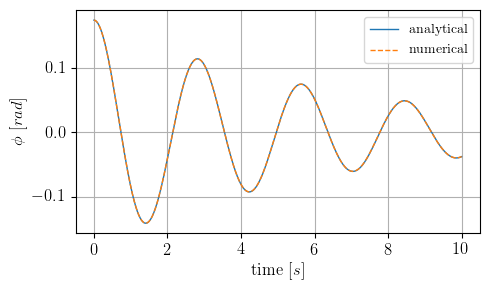

In [25]:
examples.analytical_numerical.show(omega0_lambda=omega0_lambda, 
                                   accelaration_lambda=accelaration_lambda);

# Case studies for validation
\label{sec:validation}

The hybrid method in this paper is investigated using the well known KVLCC2 test case. This ship was selected partly because it is a well known test case and also because it does not have any bilge keels. Results from roll decay simulations made with the hybrid method will be compared to corresponding model test data from the SSPA Maritime Dynamics Laboratory. From these model tests, only the total damping can be observed. Reducing the number of components by having no bilge keels will therefore give more insight into the remaining components. The main dimensions of the KVLCC2 scale model are shown in Tab.[(below)](#tab_kvlcc2_model_data) and the body plan of the full scale ship at the tested draught is shown in Fig.[(below)](#fig_body_plan). A section table can also be found in the Appendix Tab.[(here)](#tab_kvlcc2_section_table).

<a id='tab_kvlcc2_model_data'></a>

In [26]:
examples.KVLCC2.show()

$L_{pp}$,$beam$,$v_{cg}$,$k_{xx}$,$S$,$V$,$rho$,$T$
$[m]$,$[m]$,$[m]$,$[m]$,$[m^2]$,$\left[\frac{m}{s}\right]$,$\left[\frac{kg}{m^3}\right]$,$[m]$
4.706,0.853,0.27399999999999997,0.341,5.981,0.993,1000.0,0.3059


<a id='fig_body_plan'></a>

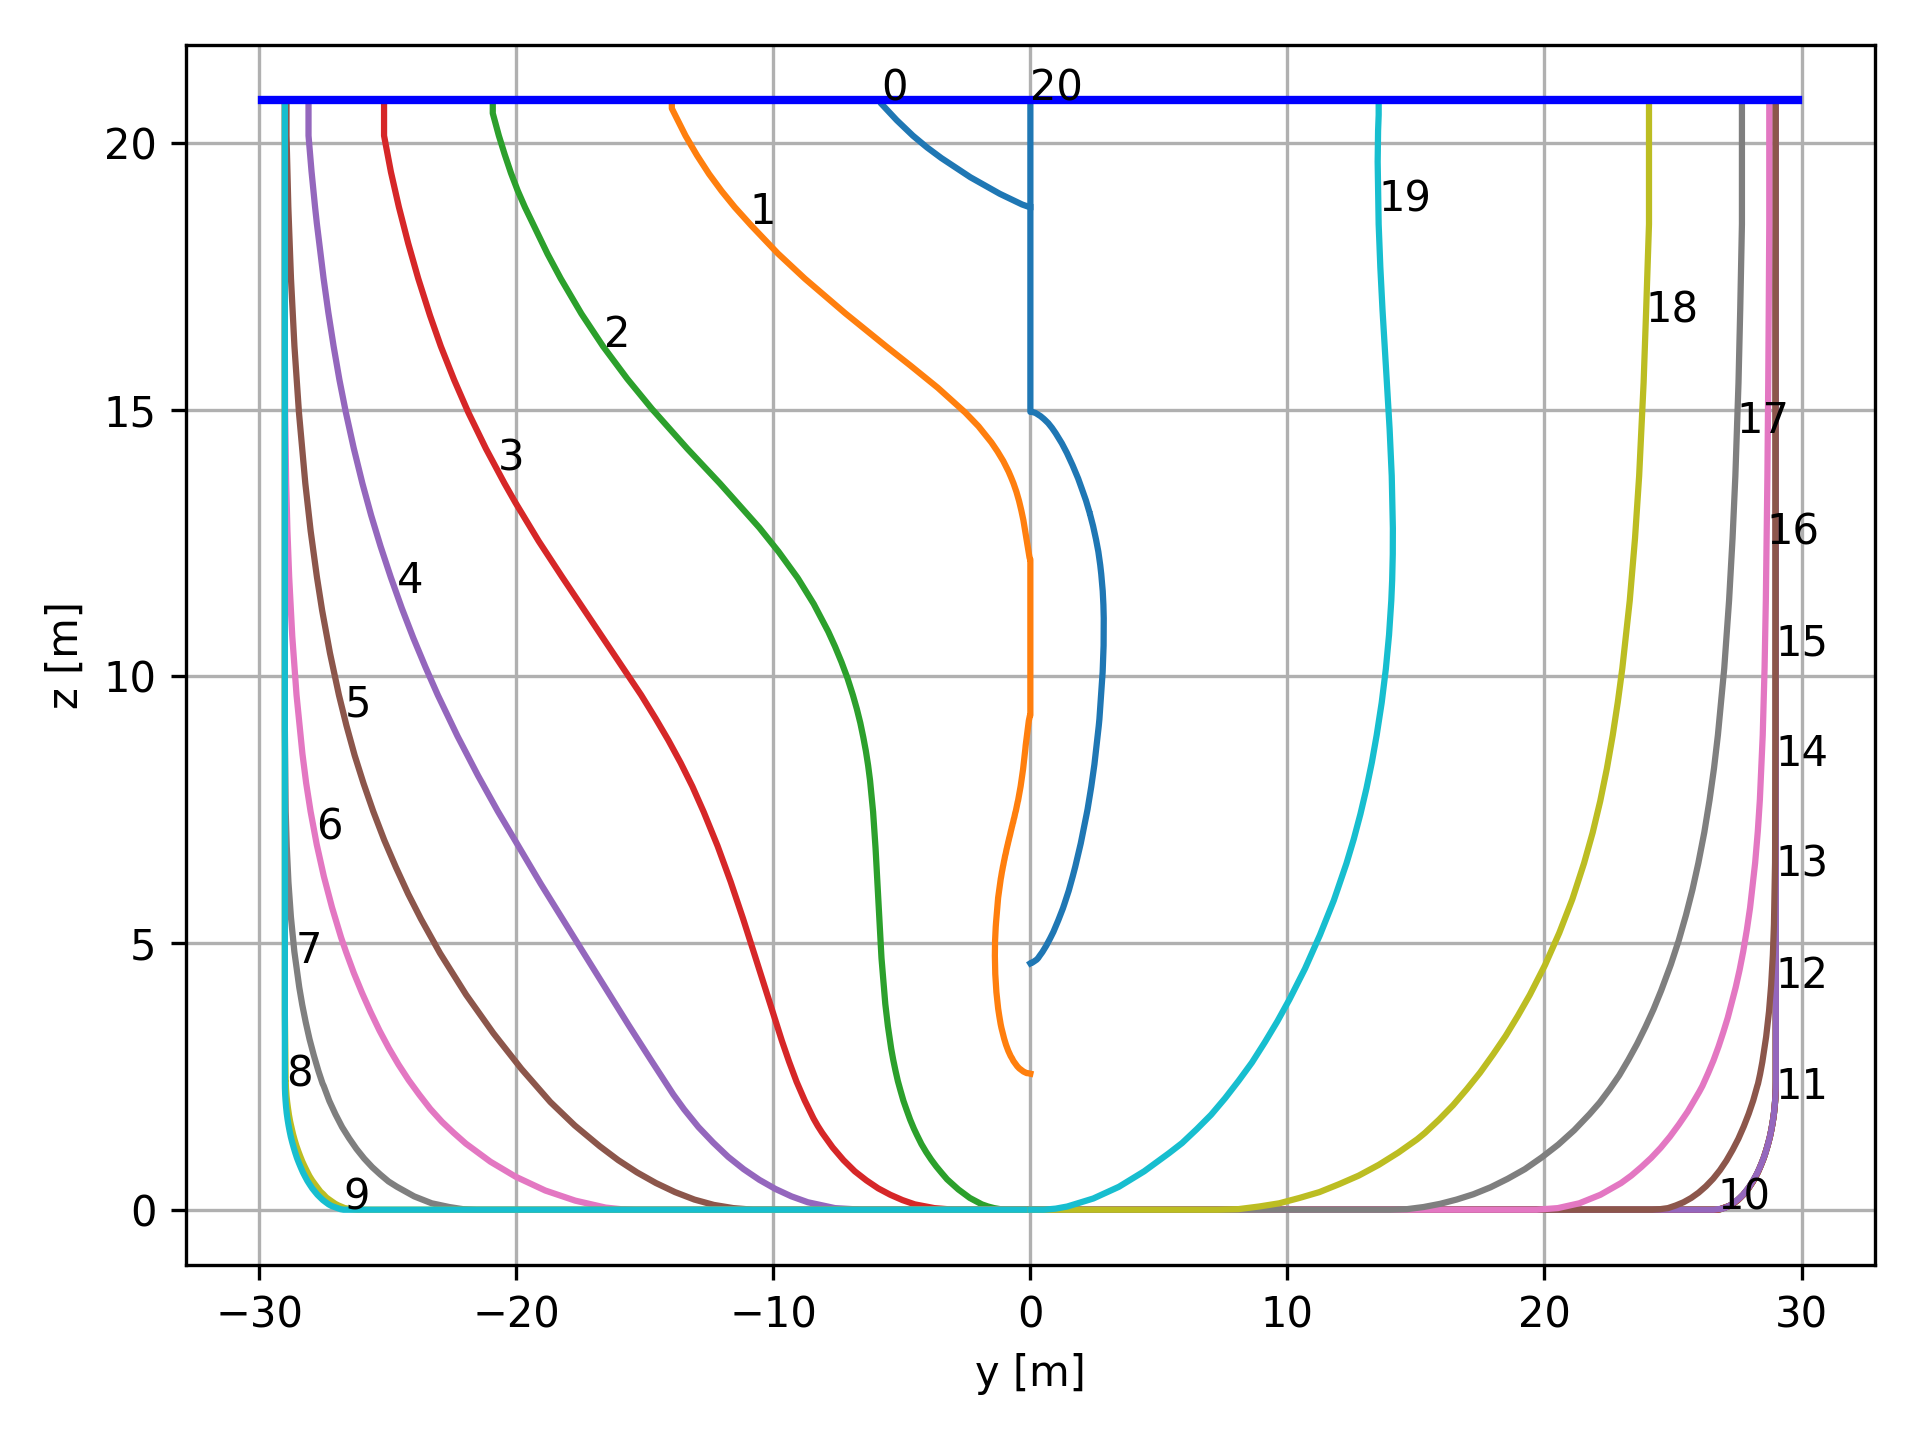

In [27]:
Image('../figures/KVLCC2_body_plan.png')

# Results

## Roll decay model tests
### Test at 0 knots
Two roll decay model tests were conducted at zero speed referred to as Run 1 and 2. [(rolldecay)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#rolldecay) These tests where analyzed by fitting a cubic model [(cubic_model)](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#cubic_model) to the model test data. The two models were very similar in terms of roll damping and stiffness (see Fig.[here](#fig_mdl)), suggesting good repeatability in both the model tests and in the parameter identification technique (PIT) used. It can be seen that the dampings, from each individual oscillation obtained with the logarithmic decrement method, are very scattered. This scatter does not seem to influence the two models for the 0 speed case, which are very similar.  

### Test at 15.5 knots
One roll decay model tests, referred to as Run 3, was conducted at a ship speed corresponding to 15.5 knots full scale ship speed (see Fig.[here](#fig_mdl)). The ship got a small yaw rate [(yaw rate)](../../notebooks/01.3_select_suitable_MDL_test_KLVCC2_speed.ipynb#yawrate) at the end of test, giving a small steady roll angle due to the centrifugal force. Since this effect is not included in the mathematical model used, the steady roll angle was instead removed by removing the linear trend in the roll angle signal. 

In [28]:
models_mdl = examples.mdl.get_models()
df_results_mdl = examples.mdl.gather_results(models_mdl)

In [29]:
amplitudes = examples.mdl.analyze_amplitudes(models=models_mdl)

<a id='fig_mdl'></a>

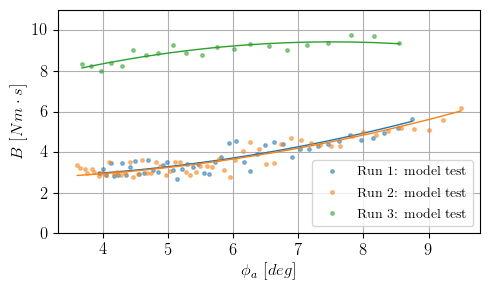

In [30]:
ylim=(0,11)
examples.mdl.show(amplitudes=amplitudes, df_results=df_results_mdl, ylim=ylim)

## Damping by Ikeda's method

The $C_r$ was calculated with regular Ikeda's method and the alternative decision tree model for the KVLCC2 with section data according to Tab.[here](#tab_kvlcc2_section_table). A comparison between these two methods are shown in Fig.[(see)](#fig_analytical_numerical). It can be seen that the regular implementation of Ikeda's method predicts much higher $C_r$ between station 8 and 14, where the bilge radius is also very small for this ship.

<a id='fig_analytical_numerical'></a>

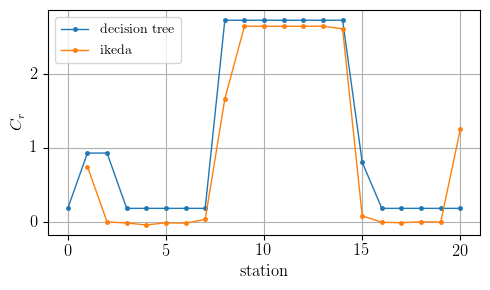

In [31]:
examples.decision_tree.show_KVLCC2_C_r_prediction()

When looking at predictions in Fig.[(here)](#fig_ikeda) for KVLCC2 at 0 speed made with regular
Ikeda's method (left), it was found that the eddy damping $B_E$ was too high
compared to the model test results. Even though the rest of the components would also be
over predicted, the $B_E$ would still be too large. The eddy damping calculated with $C_r$ predicted with the decision tree gave much better agreement and is instead used in the hybrid method.

In [32]:
models_motions, df_results_motions = reports.examples.FNPF.get_models_and_results()
amplitudes_motions = examples.FNPF.analyze_amplitudes(models=models_motions)

<a id='fig_ikeda'></a>

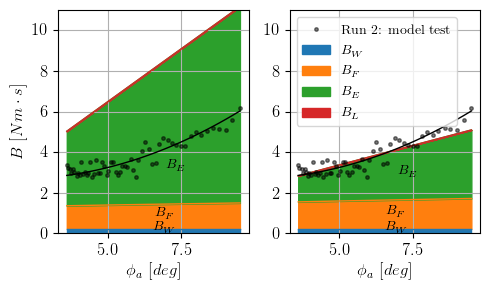

In [33]:
reports.examples.ikeda.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

## Motions estimated by FNPF
Simulations of roll decay tests were conducted with FNPF without viscous damping. Wave damping obtained from these tests are shown in Fig.[(below)](#fig_fnpf). This damping term does not seem to change much with the roll amplitude. This means that the wave damping is reasonably linear, which confirms the assumption used in the derivation of the eddy damping <cite data-cite="7505983/4AFVVGNT"></cite>.

<a id='fig_fnpf'></a>

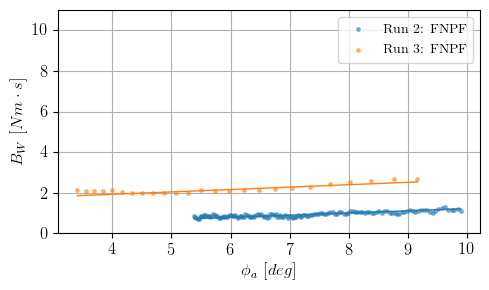

In [34]:
examples.FNPF.show(amplitudes=amplitudes_motions, df_results=df_results_motions, ylim=ylim)

## Roll motion prediction with hybrid method

In Fig.[(see)](#fig_ikeda), the wave damping $B_W$ was calculated using a linear strip theory. If this damping is instead replaced by the wave damping from FNPF (as shown in Fig.[(see)](#fig_fnpf)) the total damping is instead as shown in Fig.[(see)](#fig_hybrid_0). 

In [35]:
models_hybrid_0,df_results_hybrid_0 = examples.hybrid_0.get_models_and_results()

In [36]:
df_results = df_results_mdl.append(df_results_motions)
df_results = df_results.append(df_results_hybrid_0)

<a id='fig_hybrid_0'></a>

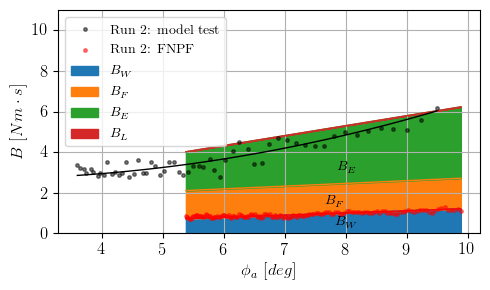

In [37]:
reports.examples.hybrid_0.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=ylim)

Results from the roll decay model test and corresponding simulations with hybrid method and FNPF method is shown in Fig.[(see)](#fig_hybrid_0_time). It is very clear that the injection of semi empirical viscous damping in the hybrid method has given a significant improvement compared to the invicid FNPF.

<a id='fig_hybrid_0_time'></a>

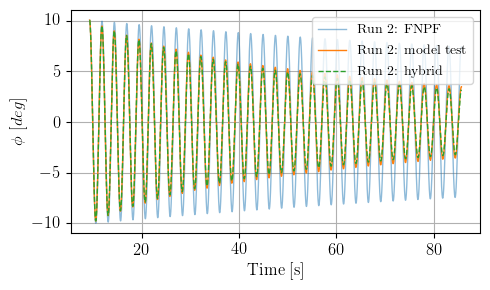

In [38]:
examples.hybrid_0.show_time(models_mdl=models_mdl, models_motions=models_motions)

The roll damping and simulated motions from the hybrid method is similar to the corresponding model test results for the zero speed case. For the in speed case the agreement is however even better as seen in the figures below.

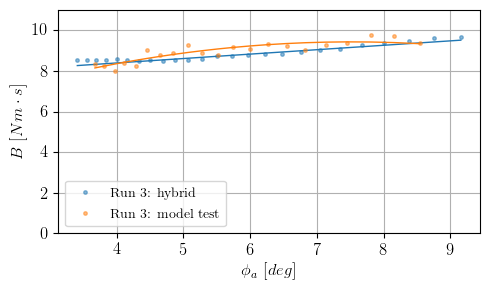

In [39]:
reports.examples.hybrid_speed.show_frequency(df_results=df_results, amplitudes=amplitudes, 
                                   amplitudes_motions=amplitudes_motions, 
                                   ylim=ylim)

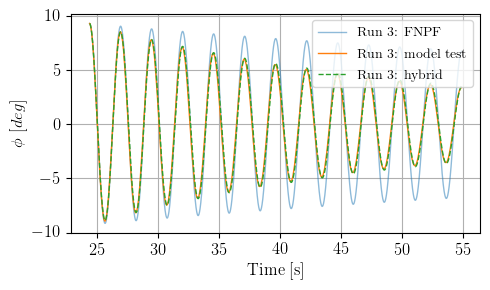

In [40]:
reports.examples.hybrid_speed.show_time(models_mdl=models_mdl, models_motions=models_motions)

The coefficients obtained from model tests, FNPF and hybrid method are summarized in model scale units in the table below. The equivalent linearized damping for 5 degrees roll angle amplitude $B_{e5}$ has also been added to this table. It can be seen that the hybrid method overpredicts the damping at 0 knots and underpredicts the damping for the higher speed for this amplitude.

In [41]:
df_table = pd.merge(left=df_results, right=mdl_results.df_rolldecays, how='inner', 
         left_on='id', right_index=True, suffixes=('','_db'))

df_table['V'] = df_table['ship_speed']*1.852/3.6
df_table['fn'] = df_table['V']/np.sqrt(df_table['g']*df_table['lpp'])
df_table['B_e_5'] = lambdas.B_e_lambda_cubic(B_1 = df_table['B_1'],
                                             B_2 = df_table['B_2'],
                                             B_3 = df_table['B_3'],
                                             omega0 = df_table['omega0'],
                                             phi_a = np.deg2rad(5)
                                            )


interesting = ['fn','method','B_1','B_2','B_3','B_e_5']

df_table_present = df_table[interesting].copy()
mask = df_table_present['method']!='FNPF'
df_table_present = df_table_present.loc[mask].copy()

rename = {
    'paper_name' : 'run',
    'fn' : r'$F_n$',
    'omega0' : r'$\omega_0$',
    'B_1' : r'$B_1$',
    'B_2' : r'$B_2$',
    'B_3' : r'$B_3$',
    'B_e_5' : r'$B_{e5}$',
}

units = {
    'fn' : r'$[-]$',
    'omega0' : r'$\left[\frac{rad}{s}\right]$',
    'B_1' : r'$[Nm \cdot s]$',
    'B_2' : r'$[Nm \cdot s^2]$',
    'B_3' : r'$[Nm \cdot s^3]$',
    'B_e_5' : r'$[Nm \cdot s]$',
}

LateXTable(df_table_present.round(decimals=2), units=units, rename=rename, 
           caption='Roll damping coefficients for model scale KVLCC2', 
           label='results')

$F_n$,method,$B_1$,$B_2$,$B_3$,$B_{e5}$
$[-]$,,$[Nm \cdot s]$,$[Nm \cdot s^2]$,$[Nm \cdot s^3]$,$[Nm \cdot s]$
0.0,model test,2.96,-6.52,43.78,3.29
0.0,model test,2.88,-5.87,41.5,3.24
0.0,hybrid,1.37,13.48,0.0,3.83
0.14,model test,4.53,35.68,-62.33,8.88
0.14,hybrid,7.52,6.01,0.0,8.61


# Conclusions
A hybrid method to predict ship roll motions has been proposed. The method combines an existing Fully Nonlinear Potential Flow Method (FNPF) with the viscous damping contributions from Ikeda's method. Simulations of roll decay test were in very good agreement with corresponding scale model tests. The method can be used to get more accurate roll motions in potential flow calculations. This is important when roll motions are of primary interest, but can also influence other motions through coupling effects or the fact that the radiated waves from the roll motions are otherwise exaggerated. The separation of viscous and invicid roll damping in Ikeda's method seem to give very good results together with the FNPF method for the KVLCC2 test case.

A new regression formula to calculate the sectional eddy damping was also proposed in this paper. The regression formula reproduced the results from Ikeda's experiments and gave much better results with the hybrid method for KVLCC2 roll decay simulations in the present study.  

# Acknowledgements
The authors would like to acknowledge Trafikverket (Swedish Transport Administration) and Lighthouse, swedish maritime competence centre (www.lighthouse.nu) for providing the resources to prepare this paper and also thank all personnel at SSPA that have been involved in the creation of the model test results: building the ship models and conducting the experiments.

# References
<div class="cite2c-biblio"></div>

# Appendix

## Lewis sections

The Lewis section coefficients were calculated as:

In [42]:
Equation(equations_ikeda_naked.eq_D_1, label='eq:D_1', max_length=300)

<src.notebook_to_latex.Equation object>

In [43]:
Equation(equations_ikeda_naked.eq_a_3, label='eq:a_3')

<src.notebook_to_latex.Equation object>

In [44]:
Equation(equations_ikeda_naked.eq_a_1, label='eq:a_1')

<src.notebook_to_latex.Equation object>

## KVLCC2
<a id='tab_kvlcc2_section_table'></a>
The section table for KVLCC2 is shown in Tab.[(see)](#tab_kvlcc2_section_table), where the lewis section coefficients have been calculated using the equations above.

<a id='tab_kvlcc2_section_table'></a>

In [45]:
examples.KVLCC2_section_table.show()

$x$,$beam$,$T_s$,$\sigma$,$\frac{OG}{d}$,$R_b$,$a_1$,$a_3$
$[m]$,$[m]$,$[m]$,$[-]$,$[-],$[m]$,$[-]$,$[-]$
-0.0808,0.1712,0.0294,0.594,1.1,0.0976,0.5341,0.0935
0.1494,0.4102,0.2684,0.2433,0.1205,0.623,-0.1824,0.3651
0.4125,0.6151,0.3059,0.4922,0.1058,0.6672,0.0032,0.1916
0.6427,0.7394,0.3059,0.6537,0.1058,0.6041,0.1024,0.0836
0.9058,0.8259,0.3059,0.7858,0.1058,0.5021,0.1489,-0.0002
1.1361,0.851,0.3059,0.878,0.1058,0.3847,0.1542,-0.0576
1.3663,0.8529,0.3059,0.9445,0.1058,0.2596,0.1482,-0.0998
1.6294,0.8529,0.3059,0.9838,0.1058,0.1404,0.144,-0.1255
1.8596,0.8529,0.3059,0.9974,0.1058,0.0566,0.1425,-0.1345


# Nomenclature

In [46]:
from reports.paper_writing import _get_symbols,_generate_latex_nomenclature
symbols_nomenclature = _get_symbols(equation_dict=equation_dict)
text = '\\vspace{-1.3cm}\n'

additional_descriptions = {
    equations.new_symbols[symbols.B_1] : 'Damping helpers',
    equations.new_symbols[symbols.B_2] : 'Damping helpers',
    equations.new_symbols[symbols.B_3] : 'Damping helpers',
    equations.new_symbols[symbols.C_1] : 'Stiffness helpers',
    equations.new_symbols[symbols.C_3] : 'Stiffness helpers',
    equations.new_symbols[symbols.C_5] : 'Stiffness helpers',
    symbols.B_1 : 'Linear damping coefficient',
    symbols.B_2 : 'Quadratic damping coefficient',
    symbols.B_3 : 'Cubic damping coefficient',
    symbols.C_1 : 'Stiffness coefficient',
    symbols.C_3 : 'Stiffness coefficient',
    symbols.C_5 : 'Stiffness coefficient',
}

additions_units = {
    symbols.B_1 : 'Nm*s',
    symbols.B_2 : 'Nm*s**2',
    symbols.B_3 : 'Nm*s**3',
    symbols.C_1 : 'Nm',
    symbols.C_3 : 'Nm',
    symbols.C_5 : 'Nm',

}

latex_nomenclature = text + _generate_latex_nomenclature(symbols=symbols_nomenclature, 
                                                        additional_descriptions=additional_descriptions,
                                                        additions_units=additions_units)
display(Latex(latex_nomenclature))

<IPython.core.display.Latex object>